In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8f16828b20>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date[0] 

'2017-08-23'

In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


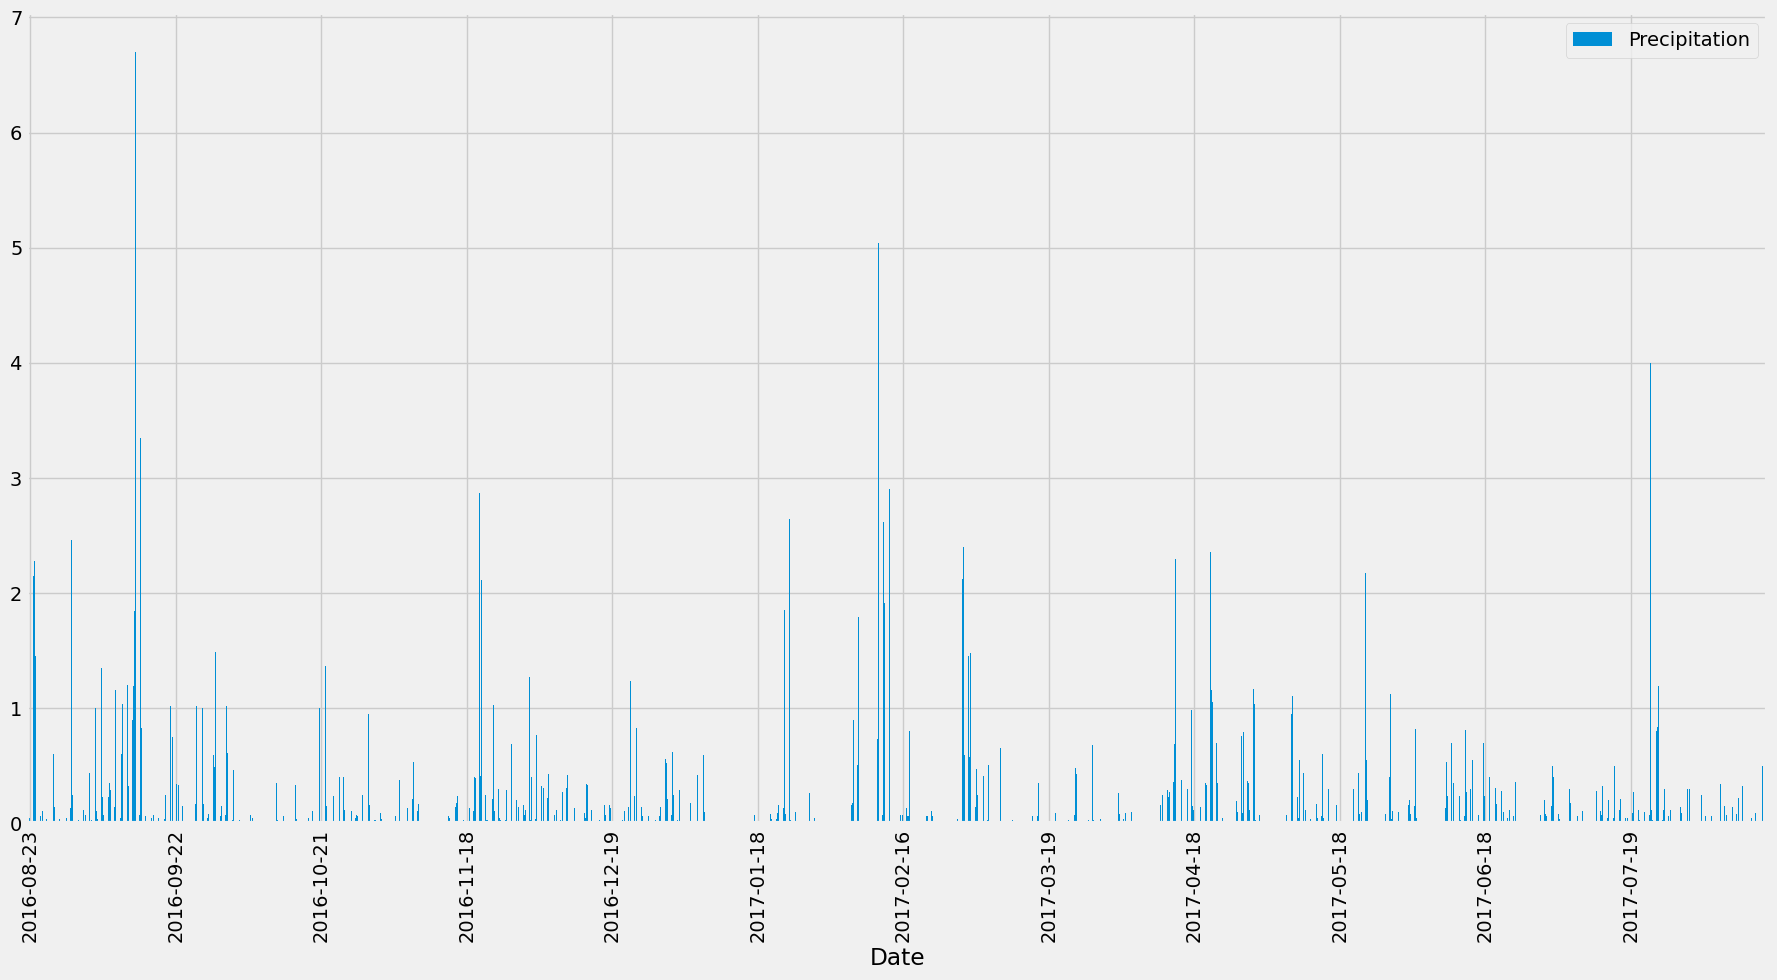

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
import matplotlib.dates as mdates
# Calculate the date one year from the last date in data set.
anniversary = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
year_data = session.query(*sel).filter(func.strftime(Measurement.date) >= anniversary).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_df = pd.DataFrame(year_data, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
year_df = year_df.sort_values(by = "Date").set_index("Date").dropna()

# Use Pandas Plotting with Matplotlib to plot the data
year_df.plot(kind = "bar", grid = True, stacked = True, figsize = (20, 10), linewidth = 0.5)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=169))

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Measurement.station).distinct().count()
stations

9

In [43]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
sel = [Measurement.station, func.count(Measurement.date)]
station_count = session.query(*sel).group_by(Measurement.station).all()

# List the stations and their counts in descending order.
# Sorting performed using https://learnpython.com/blog/sort-tuples-in-python/
station_count.sort(key = lambda a: a[1], reverse = True)
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
station_count[0][0]

'USC00519281'

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_count[0][0]
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
high_station = session.query(*sel).filter(func.strftime(Measurement.station) == station_count[0][0]).all()
high_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<Axes: xlabel='Temperature', ylabel='Frequency'>

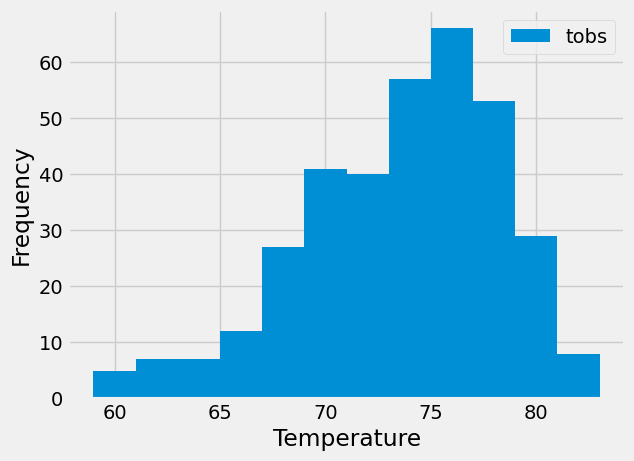

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
high_station_data = session.query(*sel).filter(func.strftime(Measurement.station) == station_count[0][0]).filter(func.strftime(Measurement.date) >= anniversary).all()
high_station_df = pd.DataFrame(high_station_data, columns = ["Date", "tobs"])
high_station_df.plot(kind = "hist", bins = 12, xlabel = "Temperature")

# Close Session

In [47]:
# Close Session
session.close()
